In [2]:
import numpy as np
from scipy.fft import rfftfreq, irfft
from scipy.interpolate import interp1d

class NoiseGenerator:
    def __init__(self, sampling_frequency, trace_samples, noise_power, noise_type='white', noise_path=None):
        self.sampling_frequency = sampling_frequency
        self.trace_samples = trace_samples
        self.noise_power = noise_power
        self.noise_type = noise_type.lower()
        self.noise_path = noise_path

        self._spectra = {}
        self._normalize = {}
        self._setup_spectra()

    def _setup_spectra(self):
        # Define analytic spectra and normalizations
        self._spectra = {
            'white': lambda f: np.ones_like(f),
            'pink': lambda f: 1.0 / np.where(f == 0, np.inf, f),
            'blue': lambda f: f,
            'violet': lambda f: f ** 2,
            'brownian': lambda f: 1.0 / np.where(f == 0, np.inf, f ** 2)
        }

        self._normalize = {
            'white': lambda f: 1.0 / (np.max(f) - np.min(f)),
            'pink': lambda f: 1.0 / (np.log(np.max(f)) - np.log(np.sort(f)[1])),
            'blue': lambda f: 2.0 / (np.max(f)**2 - np.min(f)**2),
            'violet': lambda f: 3.0 / (np.max(f)**3 - np.min(f)**3),
            'brownian': lambda f: 1.0 / (1.0 / np.sort(f)[1] - 1.0 / np.max(f)),
        }

        if self.noise_type == 'custom':
            if self.noise_path is None:
                raise ValueError("Custom noise type requires a PSD file path.")
            psd_data = np.load(self.noise_path)
            self._spectra['custom'] = interp1d(psd_data[0], psd_data[1],
                                               fill_value=(psd_data[1][0], psd_data[1][-1]),
                                               bounds_error=False)
            self._normalize['custom'] = lambda f: np.ones_like(f)

    def spectrum(self, f):
        return self._spectra[self.noise_type](f)

    def generate_noise(self):
        N = self.trace_samples
        fs = self.sampling_frequency
        f = rfftfreq(N, d=1.0 / fs)

        norm = 0.5 * self.noise_power * self._normalize[self.noise_type](f) * fs * N
        psd = norm * self.spectrum(f)

        if self.noise_type == 'custom':
            psd /= (0.5 * self.noise_power)
            psd[1:N//2 + 1 - (N + 1) % 2] *= 0.5  # Halve non-DC Nyquist if even

        psd = np.sqrt(psd)

        # Generate random phase
        phi = np.random.uniform(0, 2 * np.pi, len(psd))
        phi[0] = 0  # DC component must be real
        if N % 2 == 0:
            phi[-1] = 0  # Nyquist component must also be real for even-length FFT

        # Create spectrum and transform to time domain
        spectrum = psd * np.exp(1j * phi)
        noise = irfft(spectrum)

        # Normalize time-domain power
        noise *= np.sqrt(self.noise_power) / np.std(noise)

        return noise


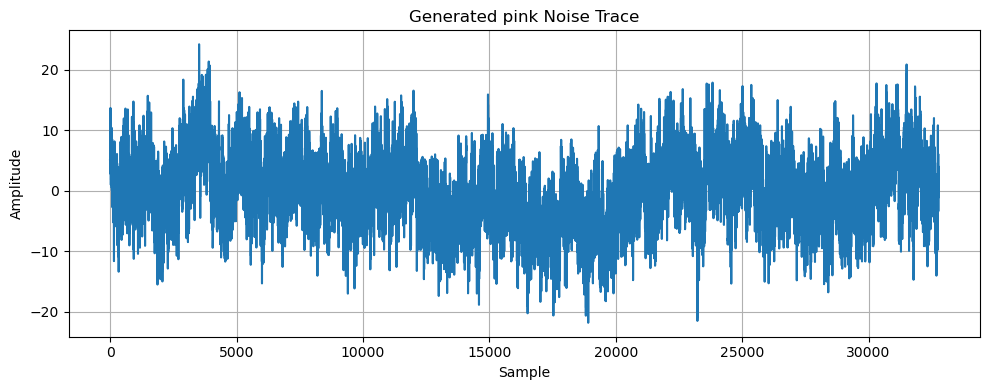

In [3]:
# Parameters
sampling_frequency = 3_906_250
trace_samples = 32768
noise_power = 33.2
noise_type = 'pink'  # or 'white', 'custom', etc.
noise_path = "/ceph/dwong/delight/templates/noise_psd_xray.npy"

# Create and generate noise
ng = NoiseGenerator(sampling_frequency, trace_samples, noise_power,
                    noise_type=noise_type, noise_path=noise_path if noise_type == 'custom' else None)
noise = ng.generate_noise()

# Plot it
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(noise)
plt.title(f"Generated {noise_type} Noise Trace")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


Mean of trace means: 0.0000e+00
Std deviation of trace means: 1.8102e-16
Expected std of means (σ/√N): 6.0767e-02
Mean of trace stds: 1.1000e+01
Expected std: 1.1000e+01


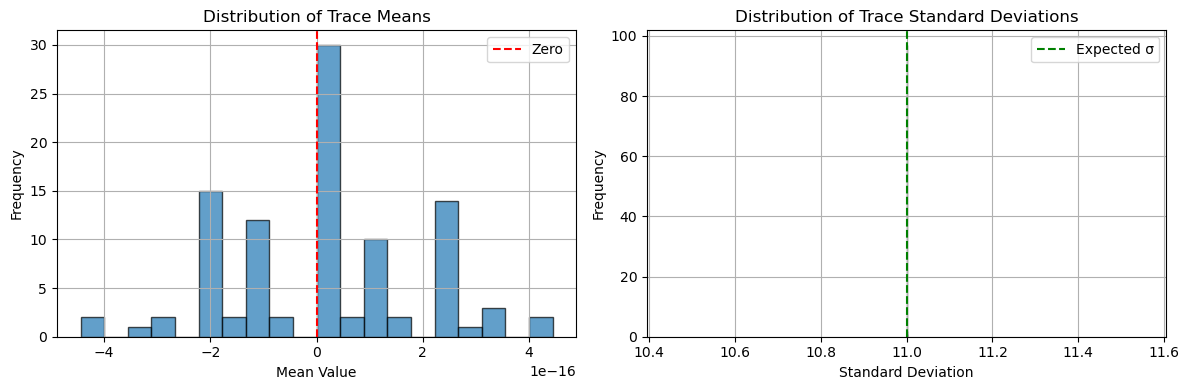

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
sampling_frequency = 3_906_250
trace_samples = 32768
noise_power = 121
noise_type = 'pink'  # or 'white', 'custom', etc.
noise_path = "/ceph/dwong/delight/templates/noise_psd_xray.npy"  # required only for 'custom'

# Initialize generator
ng = NoiseGenerator(
    sampling_frequency,
    trace_samples,
    noise_power,
    noise_type=noise_type,
    noise_path=noise_path if noise_type == 'custom' else None
)

# Generate 100 traces, compute means and standard deviations
num_traces = 100
means = []
stds = []

for _ in range(num_traces):
    trace = ng.generate_noise()
    means.append(np.mean(trace))
    stds.append(np.std(trace))

means = np.array(means)
stds = np.array(stds)

# Print statistics
expected_std = np.sqrt(noise_power)
expected_std_mean = expected_std / np.sqrt(trace_samples)

print(f"Mean of trace means: {np.mean(means):.4e}")
print(f"Std deviation of trace means: {np.std(means):.4e}")
print(f"Expected std of means (σ/√N): {expected_std_mean:.4e}")
print(f"Mean of trace stds: {np.mean(stds):.4e}")
print(f"Expected std: {expected_std:.4e}")

# --- Plotting ---
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of trace means
axs[0].hist(means, bins=20, edgecolor='k', alpha=0.7)
axs[0].axvline(0, color='red', linestyle='--', label='Zero')
axs[0].set_title("Distribution of Trace Means")
axs[0].set_xlabel("Mean Value")
axs[0].set_ylabel("Frequency")
axs[0].grid(True)
axs[0].legend()

# Histogram of trace stds
axs[1].hist(stds, bins=20, edgecolor='k', alpha=0.7)
axs[1].axvline(expected_std, color='green', linestyle='--', label='Expected σ')
axs[1].set_title("Distribution of Trace Standard Deviations")
axs[1].set_xlabel("Standard Deviation")
axs[1].set_ylabel("Frequency")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()
